In [1]:
import pandas as pd
import numpy as np
from functions import *
from models import *
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# set default plotting parameters
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})


%load_ext autoreload
%autoreload 2

**Table of contents**<a id='toc0_'></a>    
- [Create simulated values](#toc1_)    
- [Estimate models with simulated data](#toc2_)    
  - [OLS](#toc2_1_)    
    - [Linear model](#toc2_1_1_)    
    - [Non-normal model](#toc2_1_2_)    
    - [Non-linear model](#toc2_1_3_)    
  - [LASSO (OLS)](#toc2_2_)    
    - [Linear model](#toc2_2_1_)    
    - [Non-normal model](#toc2_2_2_)    
    - [Non-linear model](#toc2_2_3_)    
  - [MLP](#toc2_3_)    
    - [General setup](#toc2_3_1_)    
    - [Linear model](#toc2_3_2_)    
      - [Setup](#toc2_3_2_1_)    
      - [Training](#toc2_3_2_2_)    
      - [Prediction](#toc2_3_2_3_)    
    - [Non-normal model](#toc2_3_3_)    
      - [Setup](#toc2_3_3_1_)    
    - [Non-linear model](#toc2_3_4_)    
      - [Setup](#toc2_3_4_1_)    
      - [Training](#toc2_3_4_2_)    
      - [Prediction](#toc2_3_4_3_)    
- [Results](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Create simulated values](#toc0_)

In [2]:
# load raw data
data = pd.read_csv('data/data.csv')

# financials[(financials['ticker'] == 'INVb.CO^F05')]
baspread = data[(data['ticker'] == 'NOVOb.CO')]['baspread'].values *100
mom12m = data[(data['ticker'] == 'NOVOb.CO')]['mom12m'].values * 100
mom6m = data[(data['ticker'] == 'NOVOb.CO')]['mom6m'].values * 100
mom3m = data[(data['ticker'] == 'NOVOb.CO')]['mom3m'].values * 100
mom1m = data[(data['ticker'] == 'NOVOb.CO')]['mom1m'].values * 100

In [3]:
np.random.seed(42)
theta = 3
lambda_ = 0.05
datapoints = 100
datapoints_train = int(datapoints * 0.7)

# create simulations
x = baspread[-datapoints:]
# x_outofsample = baspread[100:200]

# linear
y1 = theta * x + np.random.normal(0, 0.01, len(x))
y1_train = y1[:datapoints_train]
y1_test = y1[datapoints_train:]

# non-normal error
y2 = theta * x + np.random.standard_t(1, len(x)) * 0.01
y2_train = y2[:datapoints_train]
y2_test = y2[datapoints_train:]


# non-linear
y3 = (theta * x)**2 + np.abs(x-lambda_) + np.random.normal(0, 0.01, len(x))
y3_train = y3[:datapoints_train]
y3_test = y3[datapoints_train:]

# make x 2 dimensional
x = x.reshape(-1, 1)

# # add momentum features to x as noise
# x_noise = np.concatenate((x, mom12m[-datapoints:].reshape(-1, 1)), axis=1)
# x_noise = np.concatenate((x_noise, mom6m[-datapoints:].reshape(-1, 1)), axis=1)
# x_noise = np.concatenate((x_noise, mom3m[-datapoints:].reshape(-1, 1)), axis=1)
# x_noise = np.concatenate((x_noise, mom1m[-datapoints:].reshape(-1, 1)), axis=1)
# x_noise = np.concatenate((np.ones((len(x), 1)), x_noise), axis=1)
# x_train_noise = x_noise[:datapoints_train]
# x_test_noise = x_noise[datapoints_train:]

# add constant term
x = np.concatenate((np.ones((len(x), 1)), x), axis=1)
x_train = x[:datapoints_train]
x_test = x[datapoints_train:]



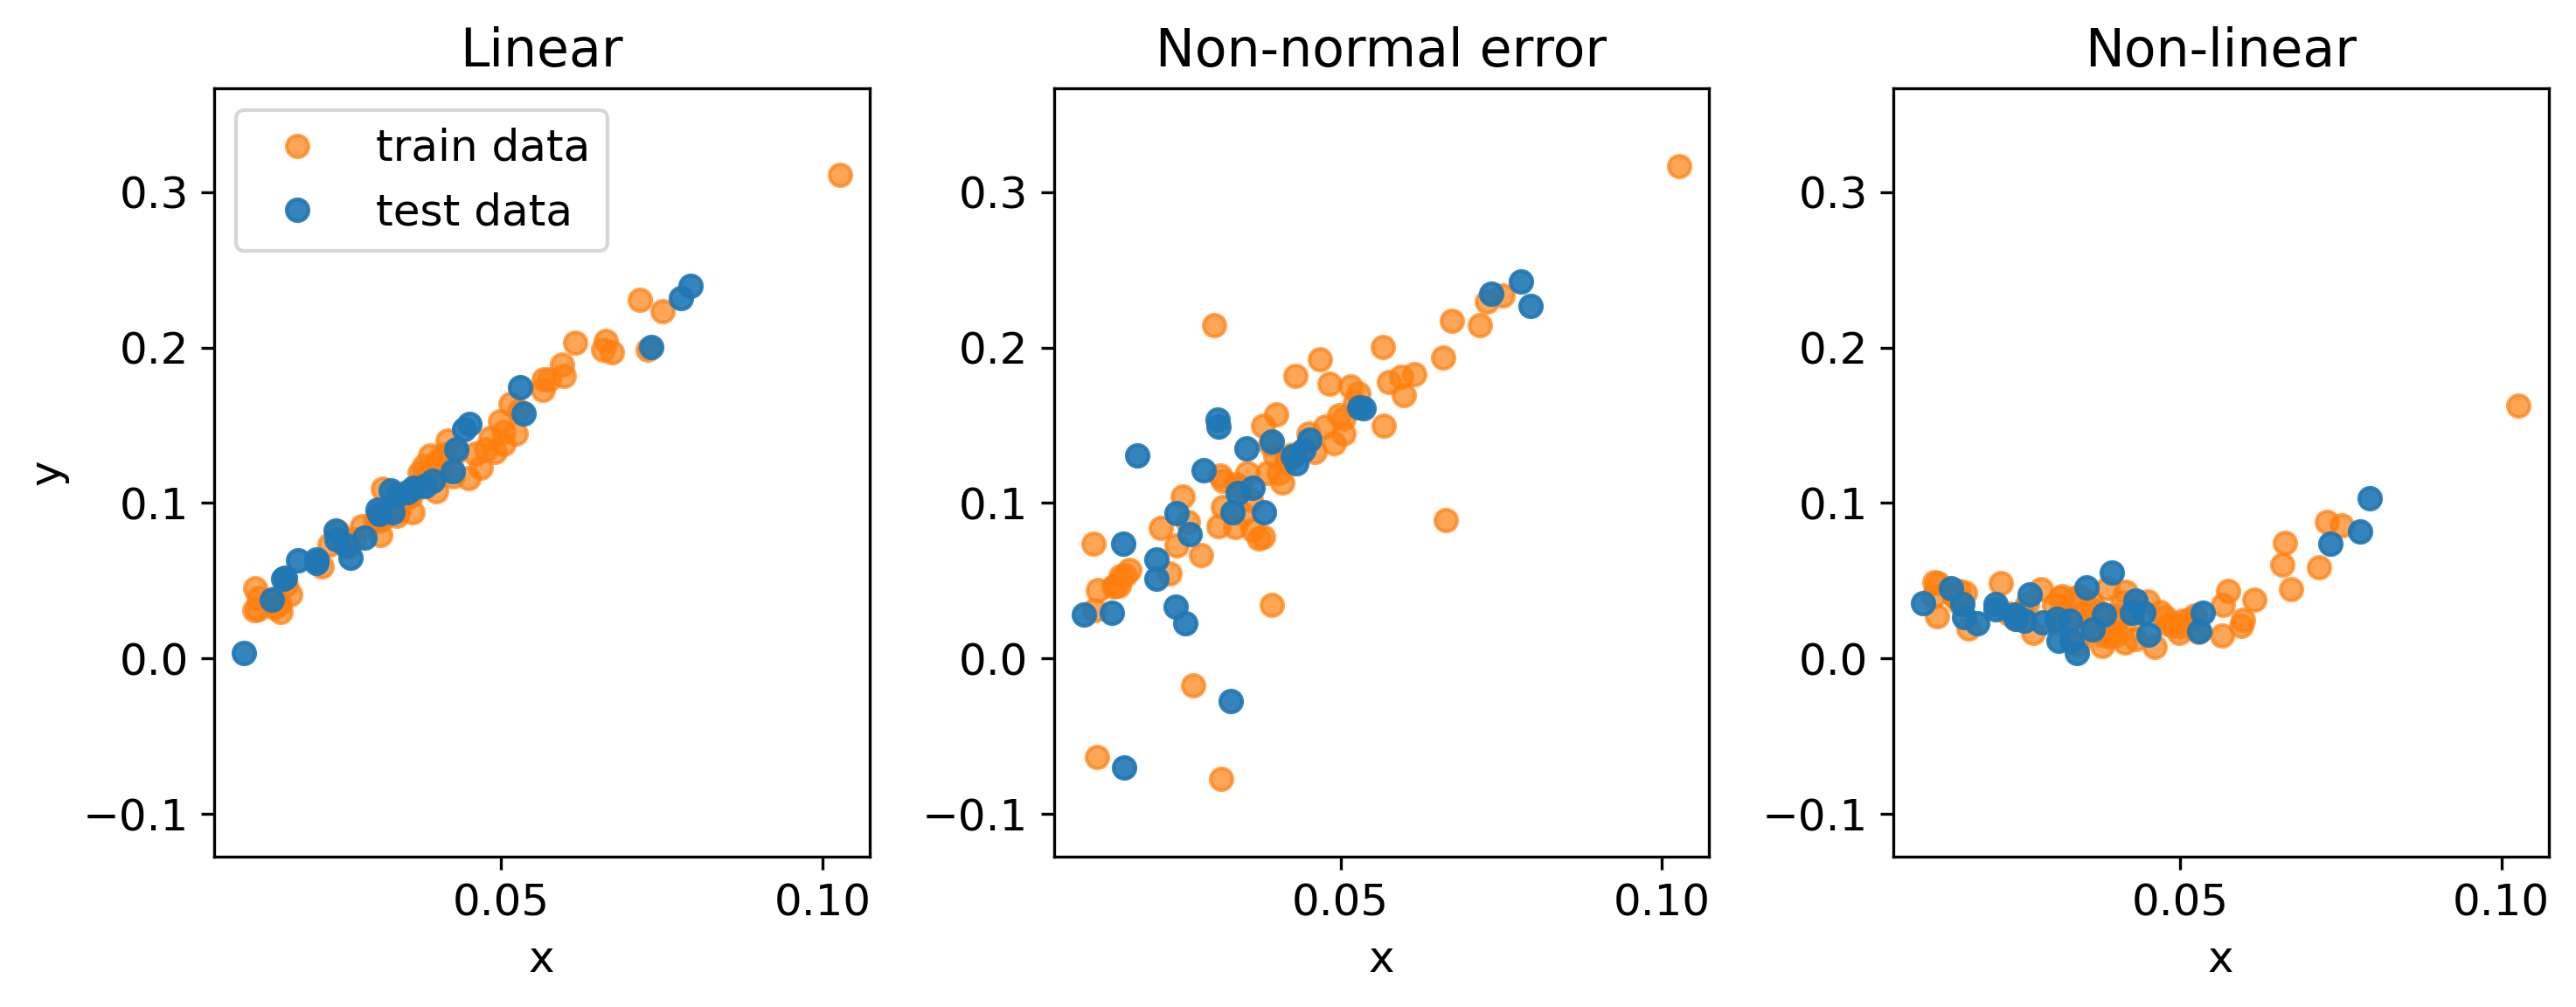

In [38]:
all_y = np.concatenate([y1_train, y1_test, y2_train, y2_test, y3_train, y3_test])
y_min, y_max = all_y.min()-0.05, all_y.max()+0.05

# plot the simulations
plt.subplot(1, 3, 1)
plt.plot(x_train[:,1], y1_train, 'o', label='train data', color='C1', alpha=0.7)
plt.plot(x_test[:,1], y1_test, 'o', label='test data', color='C0', alpha=0.9)
plt.legend(loc='upper left')
plt.ylim(y_min, y_max)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear')

plt.subplot(1, 3, 2)
plt.plot(x_train[:,1], y2_train, 'o', label='train', color='C1', alpha=0.7)
plt.plot(x_test[:,1], y2_test, 'o', label='test', color='C0', alpha=0.9)
plt.ylim(y_min, y_max)
plt.xlabel('x')
plt.title('Non-normal error')

plt.subplot(1, 3, 3)
plt.plot(x_train[:,1], y3_train, 'o', label='train', color='C1', alpha=0.7)
plt.plot(x_test[:,1], y3_test, 'o', label='test', color='C0', alpha=0.9)
plt.ylim(y_min, y_max)
plt.xlabel('x')
plt.title('Non-linear')

plt.tight_layout()
plt.savefig('output/simulation-data.png', dpi=300)
plt.show()
plt.close()

# <a id='toc2_'></a>[Estimate models with simulated data](#toc0_)

## <a id='toc2_1_'></a>[OLS](#toc0_)

### <a id='toc2_1_1_'></a>[Linear model](#toc0_)

In [5]:
# linear model
# estimate the parameters
ols_est1 = estimate(y1_train,x_train)

# for i in ols_est1:
#     print(i, ols_est1[i])

print(ols_est1['b_hat'])
print(ols_est1['se'])

ols_pred1 = ols_est1['b_hat'] @ x_test.T

[-0.00521934  3.09651467]
[[0.00265834]
 [0.06072498]]


### <a id='toc2_1_2_'></a>[Non-normal model](#toc0_)

In [6]:
# linear model
# estimate the parameters
ols_est2 = estimate(y2_train,x_train)

print(ols_est2['b_hat'])
print(ols_est2['se'])

ols_pred2 = ols_est2['b_hat'] @ x_test.T

[-0.00516583  3.10081345]
[[0.01170021]
 [0.26727014]]


### <a id='toc2_1_3_'></a>[Non-linear model](#toc0_)

In [7]:
# non-linear model
# estimate the parameters
ols_est3 = estimate(y3_train,x_train)

print(ols_est2['b_hat'])
print(ols_est2['se'])

ols_pred3 = ols_est3['b_hat'] @ x_test.T

[-0.00516583  3.10081345]
[[0.01170021]
 [0.26727014]]


## <a id='toc2_2_'></a>[LASSO (OLS)](#toc0_)

### <a id='toc2_2_1_'></a>[Linear model](#toc0_)

In [8]:
# linear model
# Create a grid using numpy.geomspace
penalty_grid = np.geomspace(1e-12, 100, num = 10000)

# Estimate the model using LassoCV
fit_CV1 = LassoCV(cv=5, alphas=penalty_grid).fit(x_train,y1_train)

# Investigate the penalty
penalty_CV1 = fit_CV1.alpha_ 
print('Penalty_CV: ', round(penalty_CV1,4))

# Investigate the coefficients
coeff_CV1 = fit_CV1.coef_
print('Coefficients: ', coeff_CV1)

lasso_pred1 = fit_CV1.predict(x_test)

Penalty_CV:  0.0
Coefficients:  [0.         3.09651467]


### <a id='toc2_2_2_'></a>[Non-normal model](#toc0_)

In [9]:
# Estimate the model using LassoCV
fit_CV2 = LassoCV(cv=5, alphas=penalty_grid).fit(x_train,y2_train)

# Investigate the penalty
penalty_CV2 = fit_CV2.alpha_ 
print('Penalty_CV: ', round(penalty_CV2,4))

# Investigate the coefficients
coeff_CV2 = fit_CV2.coef_
print('Coefficients: ', coeff_CV2)

lasso_pred2 = fit_CV2.predict(x_test)

Penalty_CV:  0.0
Coefficients:  [0.         3.03997885]


### <a id='toc2_2_3_'></a>[Non-linear model](#toc0_)

In [10]:
# Estimate the model using LassoCV
fit_CV3 = LassoCV(cv=5, alphas=penalty_grid).fit(x_train,y3_train)

# Investigate the penalty
penalty_CV3 = fit_CV3.alpha_ 
print('Penalty_CV: ', round(penalty_CV3,4))

# Investigate the coefficients
coeff_CV = fit_CV3.coef_
print('Coefficients: ', coeff_CV)

lasso_pred3 = fit_CV3.predict(x_test)

Penalty_CV:  0.0
Coefficients:  [0.         0.55756334]


## <a id='toc2_3_'></a>[MLP](#toc0_)

### <a id='toc2_3_1_'></a>[General setup](#toc0_)

In [11]:
# remove constant as bias is included in the model
scaler_x, scaler_y1, scaler_y2, scaler_y3 = StandardScaler(), StandardScaler(), StandardScaler(), StandardScaler()
x_train_mlp = scaler_x.fit_transform(x_train[:,1][:9*(datapoints_train//10)].reshape(-1, 1))
x_val_mlp = scaler_x.transform(x_train[:,1][9*(datapoints_train//10):].reshape(-1, 1))
x_test_mlp = scaler_x.transform(x_test[:,1].reshape(-1, 1))

y1_train_mlp = scaler_y1.fit_transform(y1_train[:9*(datapoints_train//10)].reshape(-1, 1))
y1_val_mlp = scaler_y1.transform(y1_train[9*(datapoints_train//10):].reshape(-1, 1))
y1_test_mlp = scaler_y1.transform(y1_test.reshape(-1, 1))

y2_train_mlp = scaler_y2.fit_transform(y2_train[:9*(datapoints_train//10)].reshape(-1, 1))
y2_val_mlp = scaler_y2.transform(y2_train[9*(datapoints_train//10):].reshape(-1, 1))
y2_test_mlp = scaler_y2.transform(y2_test.reshape(-1, 1))

y3_train_mlp = scaler_y3.fit_transform(y3_train[:9*(datapoints_train//10)].reshape(-1, 1))
y3_val_mlp = scaler_y3.transform(y3_train[9*(datapoints_train//10):].reshape(-1, 1))
y3_test_mlp = scaler_y3.transform(y3_test.reshape(-1, 1))

In [ ]:
# moving to metal or CUDA GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using device:", device)

# general hyperparameters
input_dim = x_train_mlp.shape[1]
hidden_depth = 1 # excluding output layer
hidden_width = 2 # int for all being equal width; list for different widths
learning_rate = 1e-3
activation_fun = nn.ReLU # nn.ReLU nn.Tanh nn.Sigmoid nn.LeakyReLU nn.Identity

# general critereon and regularization parameters
criterion = nn.MSELoss()
lambda_l1 = 0 # 1e-4
lambda_l2 = 0 # 1e-4

# general parmeters
patience = 1000
print_freq = 100
epochs = 1000

Using device: mps


### <a id='toc2_3_2_'></a>[Linear model](#toc0_)

#### <a id='toc2_3_2_1_'></a>[Setup](#toc0_)

In [13]:
# linear model
np.random.seed(42)
torch.manual_seed(42)

# create dataset objects for training and validation
train_dataset = MLPdataset(x_train_mlp, y1_train_mlp)
val_dataset = MLPdataset(x_val_mlp, y1_val_mlp)
# dataloaders for batching
train_loader = DataLoader(train_dataset, 
                        #   batch_size=64, 
                        #   shuffle=True
                          )
val_loader = DataLoader(val_dataset, 
                        # batch_size=64, 
                        # shuffle=False
                        )

model1 = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)

optimizer = optim.Adam(model1.parameters(), lr=1e-3)

best_val_loss = float('inf')
best_model1 = None


#### <a id='toc2_3_2_2_'></a>[Training](#toc0_)

In [14]:
for epoch in range(epochs):
    model1.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        # move data to GPU if available
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model1(batch_X)
        loss = criterion(outputs, batch_y)
        
        # L1 and L2 regularization losses
        loss += l1_regularization(model1, lambda_l1)
        loss += l2_regularization(model1, lambda_l2)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
    train_loss /= len(train_dataset)
    
    # validation
    model1.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model1(batch_X)
            loss = criterion(outputs, batch_y)
            # Optionally, add reg losses to validation loss if you want to monitor them:
            loss += l1_regularization(model1, lambda_l1)
            loss += l2_regularization(model1, lambda_l2)
            val_loss += loss.item() * batch_X.size(0)
    val_loss /= len(val_dataset)

    if (epoch+1) % print_freq == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.5E}, Validation Loss: {val_loss:.5E}")

    # early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model1 = model1
        # torch.save(best_model.state_dict(), 'output/best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.5E}")
            break
    

Epoch 100/1000 - Train Loss: 2.30598E-02, Validation Loss: 3.20538E-02
Epoch 200/1000 - Train Loss: 2.28534E-02, Validation Loss: 3.26128E-02
Epoch 300/1000 - Train Loss: 2.28420E-02, Validation Loss: 3.26600E-02
Epoch 400/1000 - Train Loss: 2.28341E-02, Validation Loss: 3.26725E-02
Epoch 500/1000 - Train Loss: 2.28246E-02, Validation Loss: 3.26829E-02
Epoch 600/1000 - Train Loss: 2.28225E-02, Validation Loss: 3.26669E-02
Epoch 700/1000 - Train Loss: 2.28175E-02, Validation Loss: 3.26581E-02
Epoch 800/1000 - Train Loss: 2.28118E-02, Validation Loss: 3.26614E-02
Epoch 900/1000 - Train Loss: 2.28076E-02, Validation Loss: 3.26532E-02
Epoch 1000/1000 - Train Loss: 2.28024E-02, Validation Loss: 3.26591E-02


#### <a id='toc2_3_2_3_'></a>[Prediction](#toc0_)

In [15]:
test_dataset = MLPdataset(x_test_mlp, y1_test_mlp)    # if you don’t have y_test, you can pass dummy zeros
test_loader = DataLoader(test_dataset, 
                        #  batch_size=64, 
                         shuffle=False
                         )

# 3) Run the model in eval mode and collect predictions
best_model1.eval()
mlp_pred1 = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = best_model1(batch_X) # shape: (batch_size, 1)
        
        # Move back to CPU and flatten
        preds = outputs.cpu().numpy().flatten()
        mlp_pred1.extend(preds)

# convert to array
mlp_pred1_scaled = np.array(mlp_pred1)
mlp_pred1 = scaler_y1.inverse_transform(mlp_pred1_scaled.reshape(-1, 1)).flatten()

In [16]:
# for idx, layer in enumerate(model1.network):
#     if isinstance(layer, nn.Linear):
#         W = layer.weight.detach().cpu().numpy()
#         b = layer.bias.detach().cpu().numpy()
#         print(f"Linear layer #{idx}: weight shape={W.shape}, bias shape={b.shape}")
#         print(W, "\n", b, "\n")

### <a id='toc2_3_3_'></a>[Non-normal model](#toc0_)


#### <a id='toc2_3_3_1_'></a>[Setup](#toc0_)

In [17]:
np.random.seed(42)
torch.manual_seed(42)

# create dataset objects for training and validation
train_dataset = MLPdataset(x_train_mlp, y2_train_mlp)
val_dataset = MLPdataset(x_val_mlp, y2_val_mlp)
# dataloaders for batching
train_loader = DataLoader(train_dataset, 
                        #   batch_size=64, 
                        #   shuffle=True
                          )
val_loader = DataLoader(val_dataset, 
                        # batch_size=64, 
                        # shuffle=False
                        )

model2 = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)

optimizer = optim.Adam(model2.parameters(), lr=1e-3)

best_val_loss = float('inf')
best_model2 = None

In [18]:
for epoch in range(epochs):
    model2.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        # move data to GPU if available
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model2(batch_X)
        loss = criterion(outputs, batch_y)
        
        # L1 and L2 regularization losses
        loss += l1_regularization(model2, lambda_l1)
        loss += l2_regularization(model2, lambda_l2)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
    train_loss /= len(train_dataset)
    
    # validation
    model2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model2(batch_X)
            loss = criterion(outputs, batch_y)
            # Optionally, add reg losses to validation loss if you want to monitor them:
            loss += l1_regularization(model2, lambda_l1)
            loss += l2_regularization(model2, lambda_l2)
            val_loss += loss.item() * batch_X.size(0)
    val_loss /= len(val_dataset)

    if (epoch+1) % print_freq == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.5E}, Validation Loss: {val_loss:.5E}")

    # early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model2 = model2
        # torch.save(best_model.state_dict(), 'output/best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.5E}")
            break
    

Epoch 100/1000 - Train Loss: 3.49035E-01, Validation Loss: 1.39756E-01
Epoch 200/1000 - Train Loss: 3.43332E-01, Validation Loss: 1.45377E-01
Epoch 300/1000 - Train Loss: 3.41424E-01, Validation Loss: 1.56684E-01
Epoch 400/1000 - Train Loss: 3.40890E-01, Validation Loss: 1.68519E-01
Epoch 500/1000 - Train Loss: 3.40621E-01, Validation Loss: 1.75051E-01
Epoch 600/1000 - Train Loss: 3.40448E-01, Validation Loss: 1.77210E-01
Epoch 700/1000 - Train Loss: 3.40314E-01, Validation Loss: 1.76404E-01
Epoch 800/1000 - Train Loss: 3.40156E-01, Validation Loss: 1.71266E-01
Epoch 900/1000 - Train Loss: 3.38960E-01, Validation Loss: 1.53018E-01
Epoch 1000/1000 - Train Loss: 3.38524E-01, Validation Loss: 1.44002E-01


In [19]:
test_dataset = MLPdataset(x_test_mlp, y2_test_mlp)    # if you don’t have y_test, you can pass dummy zeros
test_loader = DataLoader(test_dataset, 
                        #  batch_size=64, 
                         shuffle=False
                         )

# run the model in eval mode and collect predictions
best_model2.eval()
mlp_pred2 = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = best_model2(batch_X) # shape: (batch_size, 1)
        
        # Move back to CPU and flatten
        preds = outputs.cpu().numpy().flatten()
        mlp_pred2.extend(preds)

# convert to array
mlp_pred2_scaled = np.array(mlp_pred2)
mlp_pred2 = scaler_y2.inverse_transform(mlp_pred2_scaled.reshape(-1, 1)).flatten()

### <a id='toc2_3_4_'></a>[Non-linear model](#toc0_)

#### <a id='toc2_3_4_1_'></a>[Setup](#toc0_)

In [20]:
# non-linear model
np.random.seed(42)
torch.manual_seed(42)

# train_dataset = MLPdataset(x_train_mlp, y3_train_mlp) 

# create dataset objects for training and validation
train_dataset = MLPdataset(x_train_mlp, y3_train_mlp) # removing constant term
val_dataset = MLPdataset(x_val_mlp, y3_val_mlp) # removing constant term
# dataloaders for batching
train_loader = DataLoader(train_dataset, 
                        #   batch_size=64, 
                        #   shuffle=True
                          )
val_loader = DataLoader(val_dataset, 
                        # batch_size=64, 
                        # shuffle=False
                        )

model3 = MLPModel(input_dim,depth=hidden_depth,width=hidden_width,activation=activation_fun).to(device)

optimizer = optim.Adam(model3.parameters(), lr=1e-3)

best_val_loss = float('inf')
best_model3 = None

#### <a id='toc2_3_4_2_'></a>[Training](#toc0_)

In [21]:
for epoch in range(epochs):
    model3.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        # move data to GPU if available
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model3(batch_X)
        loss = criterion(outputs, batch_y)
        
        # L1 and L2 regularization losses
        loss += l1_regularization(model3, lambda_l1)
        loss += l2_regularization(model3, lambda_l2)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
    train_loss /= len(train_dataset)


    # validation
    model3.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model3(batch_X)
            loss = criterion(outputs, batch_y)
            # Optionally, add reg losses to validation loss if you want to monitor them:
            loss += l1_regularization(model3, lambda_l1)
            loss += l2_regularization(model3, lambda_l2)
            val_loss += loss.item() * batch_X.size(0)
    val_loss /= len(val_dataset)

    if (epoch+1) % print_freq == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.5E}, Validation Loss: {val_loss:.5E}")

    # early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model3 = model3
        # torch.save(best_model.state_dict(), 'output/best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.5E}")
            break
# best_model3 = model3
    

Epoch 100/1000 - Train Loss: 2.05402E-01, Validation Loss: 1.38607E-01
Epoch 200/1000 - Train Loss: 1.91842E-01, Validation Loss: 1.52333E-01
Epoch 300/1000 - Train Loss: 1.91783E-01, Validation Loss: 1.53865E-01
Epoch 400/1000 - Train Loss: 1.91763E-01, Validation Loss: 1.54072E-01
Epoch 500/1000 - Train Loss: 1.91747E-01, Validation Loss: 1.53613E-01
Epoch 600/1000 - Train Loss: 1.91721E-01, Validation Loss: 1.54055E-01
Epoch 700/1000 - Train Loss: 1.91698E-01, Validation Loss: 1.54630E-01
Epoch 800/1000 - Train Loss: 1.91690E-01, Validation Loss: 1.55022E-01
Epoch 900/1000 - Train Loss: 1.91689E-01, Validation Loss: 1.55381E-01
Epoch 1000/1000 - Train Loss: 1.91684E-01, Validation Loss: 1.55656E-01


#### <a id='toc2_3_4_3_'></a>[Prediction](#toc0_)

In [22]:
test_dataset = MLPdataset(x_test_mlp, y3_test_mlp)
test_loader = DataLoader(test_dataset, 
                        #  batch_size=64, 
                         shuffle=False
                         )

# 3) Run the model in eval mode and collect predictions
best_model3.eval()
mlp_pred3 = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = best_model3(batch_X) # shape: (batch_size, 1)
        
        # Move back to CPU and flatten
        preds = outputs.cpu().numpy().flatten()
        mlp_pred3.extend(preds)

# convert to array
mlp_pred3_scaled = np.array(mlp_pred3)
mlp_pred3 = scaler_y3.inverse_transform(mlp_pred3_scaled.reshape(-1, 1)).flatten()

# <a id='toc3_'></a>[Results](#toc0_)

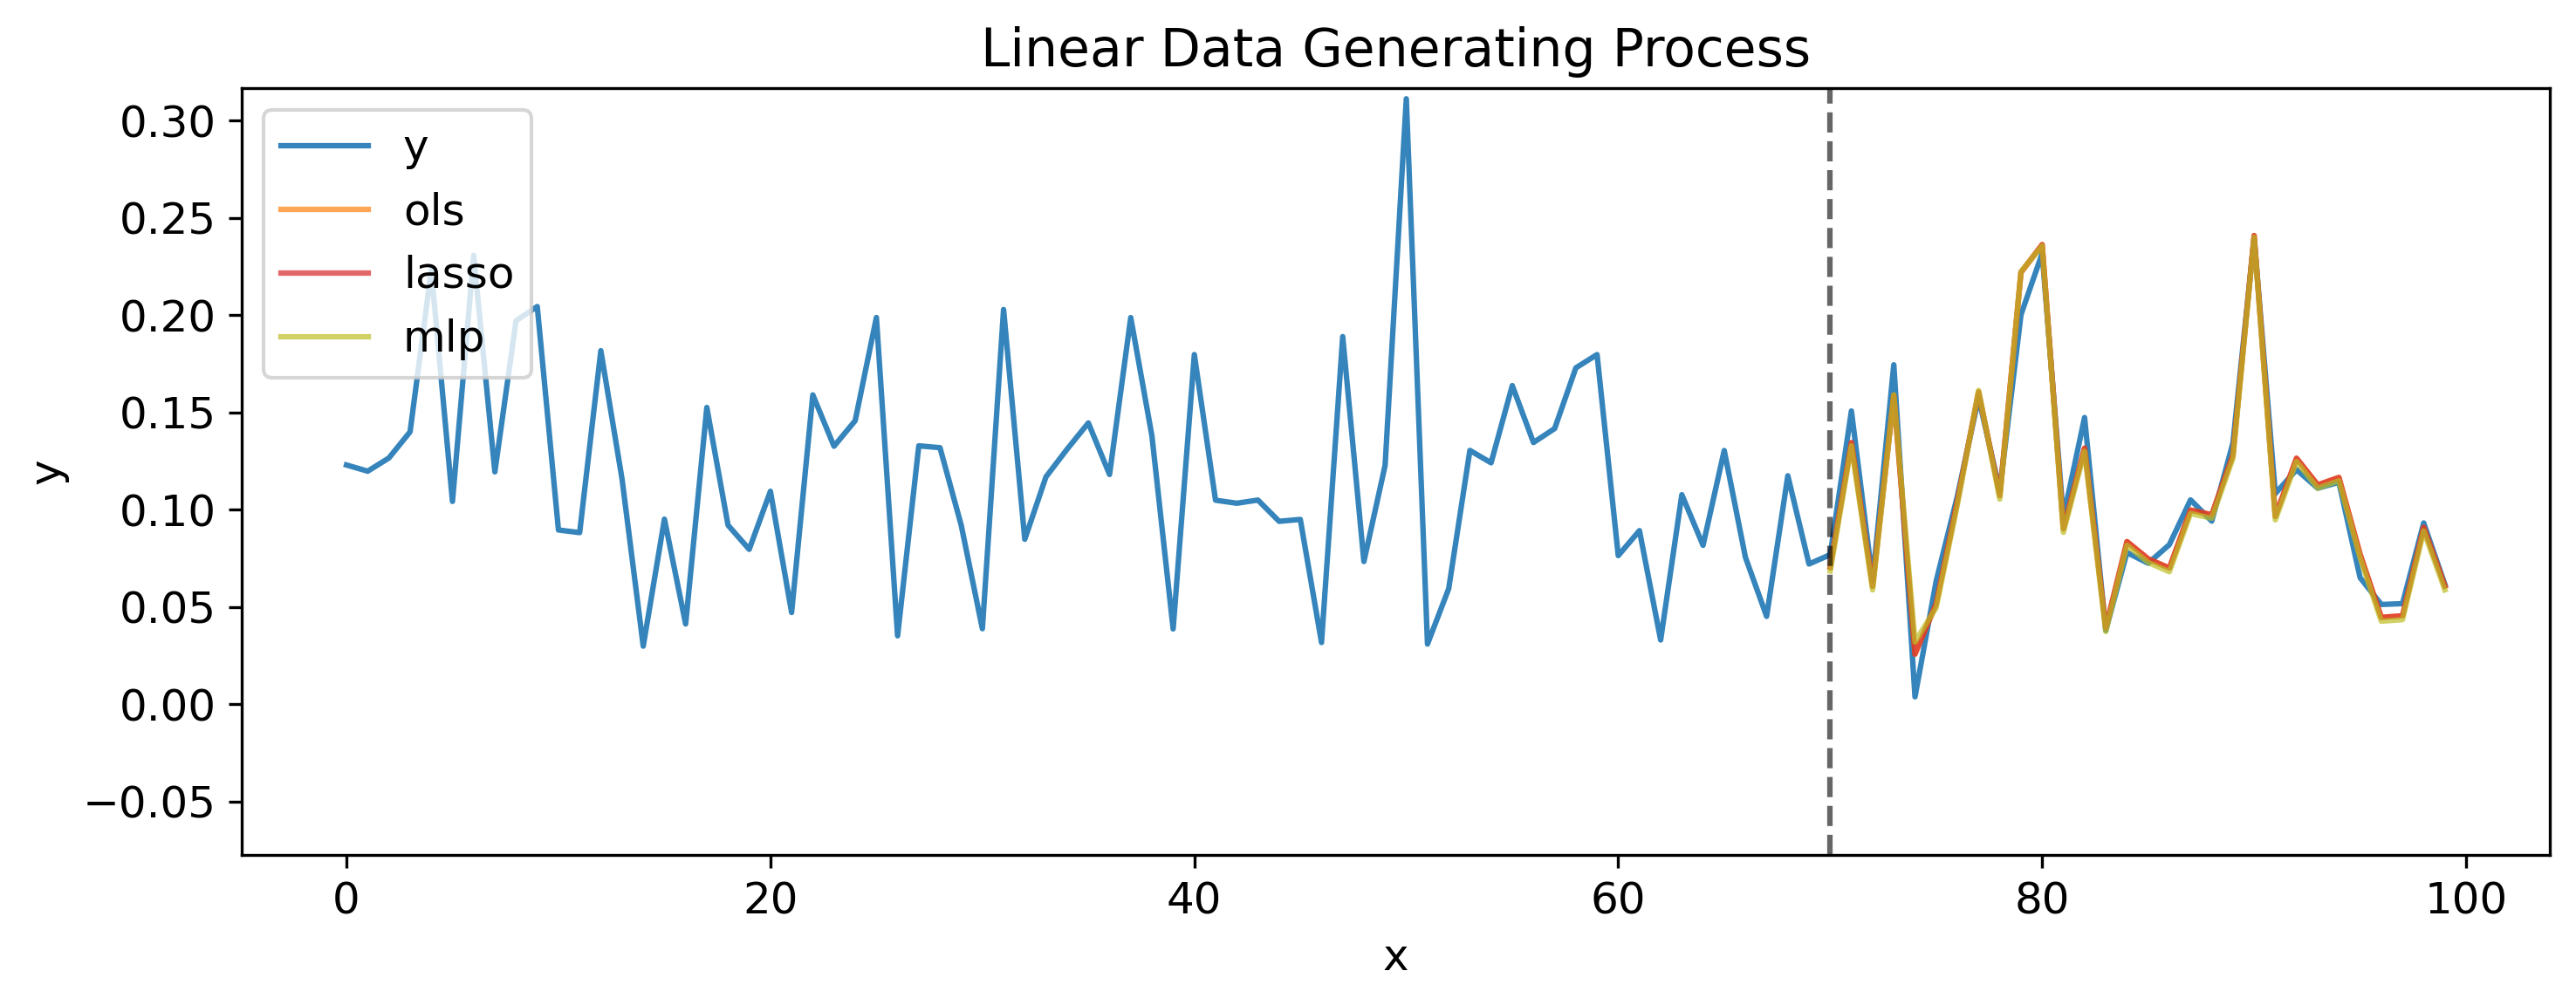

In [23]:
n_train = np.arange(len(x_train))
n_test  = np.arange(len(x_train), len(x))
n_full  = np.arange(len(x))

plt.plot(n_full, y1, label='y', color='C0', alpha=0.9)
# plt.plot(n_full, x[:,1], label='x', color='C6', alpha=0.7)

plt.plot(n_test, ols_pred1, label='ols', color='C1', alpha=0.7)
plt.plot(n_test, lasso_pred1, label='lasso', color='C3',  alpha=0.7)
plt.plot(n_test, mlp_pred1, label='mlp', color='C8', alpha=0.7)

plt.axvline(len(x_train), color='k', linestyle='--', alpha=0.6)

plt.legend(loc='upper left')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear Data Generating Process")
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.savefig('output/linear.png', dpi=300)
plt.show()
plt.close()

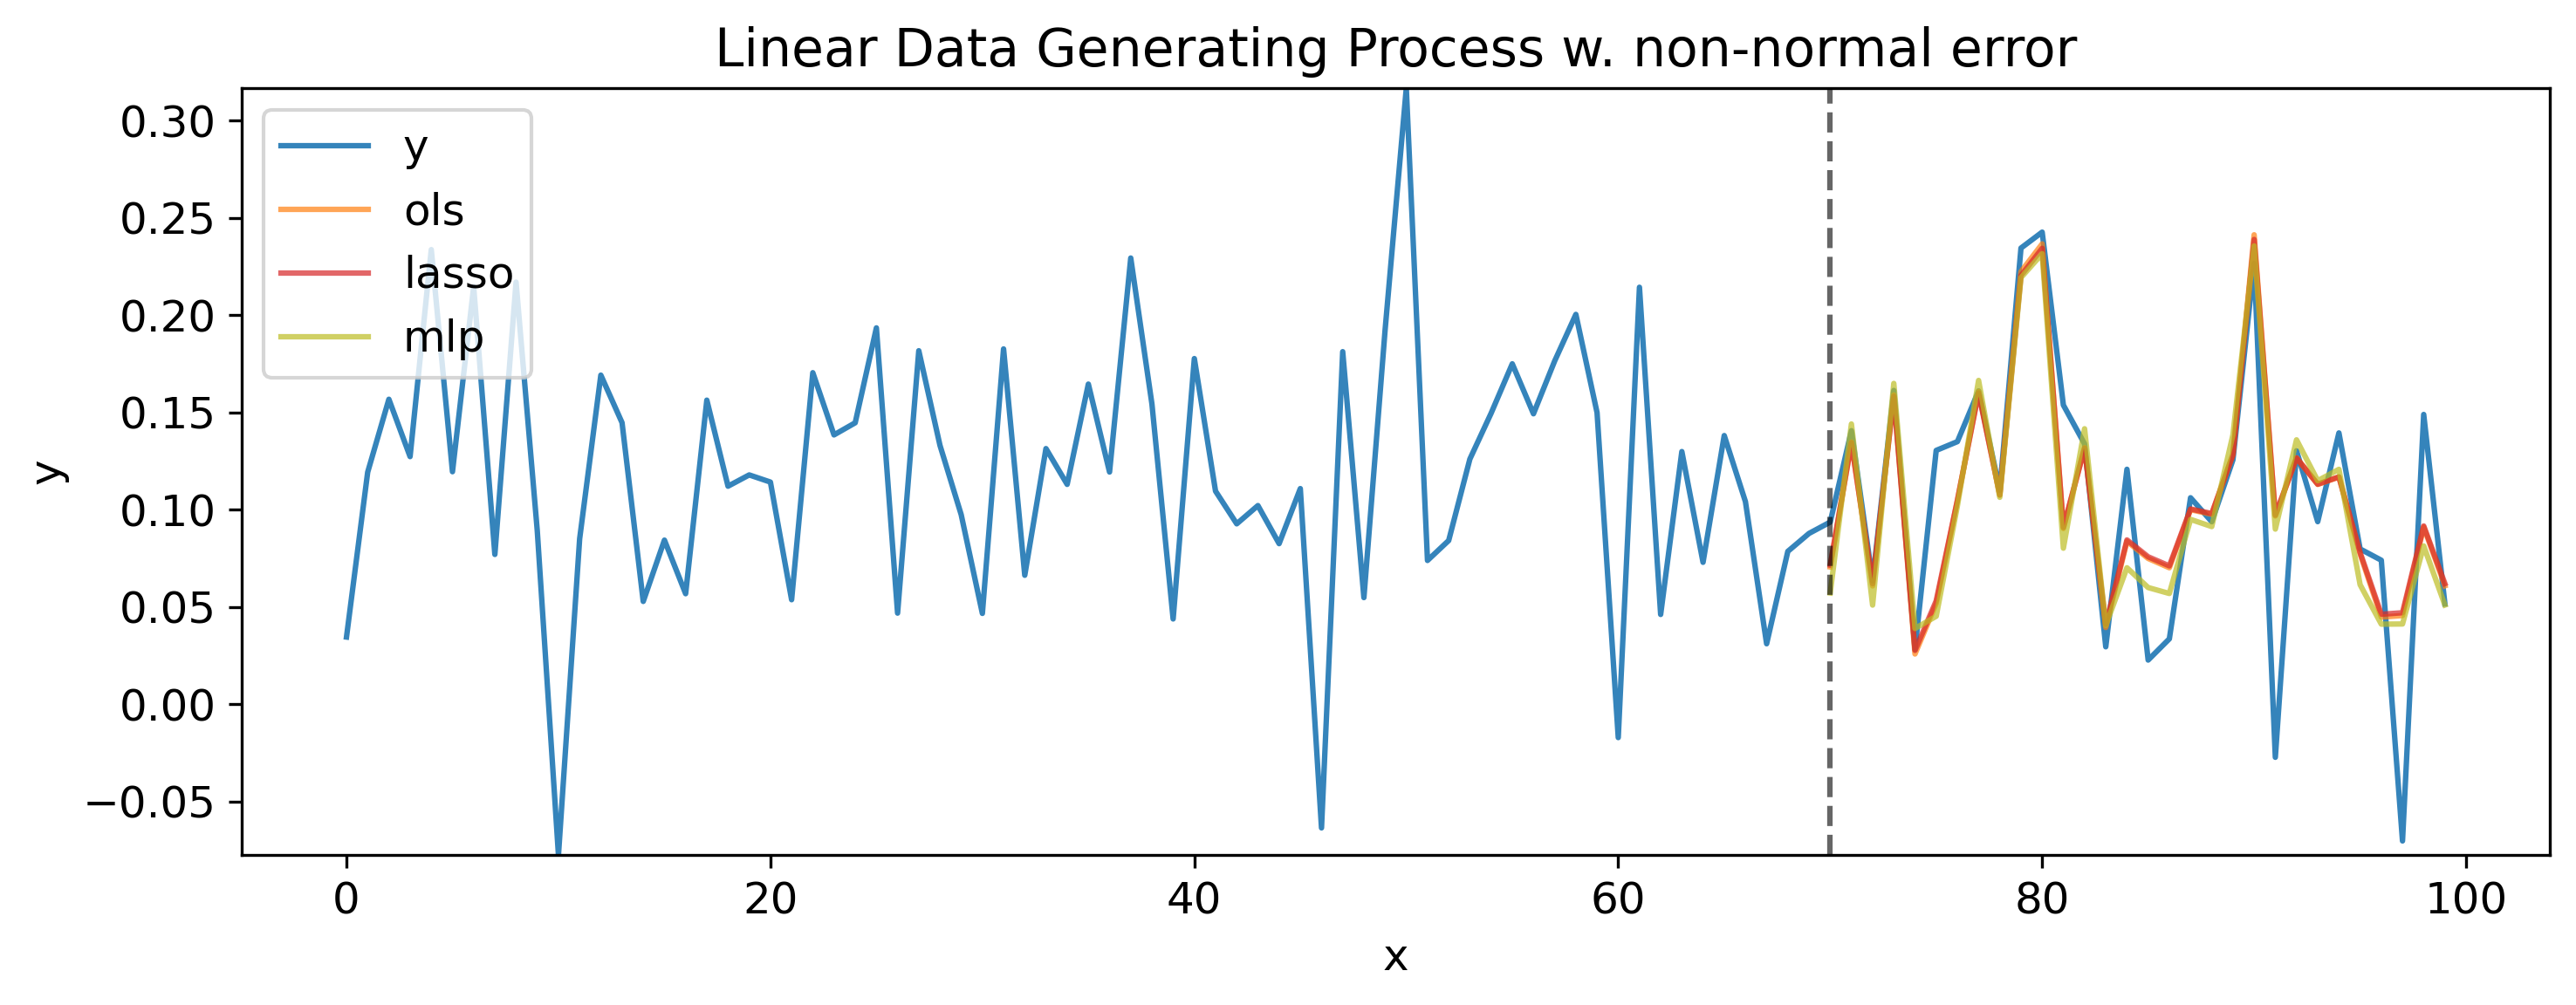

In [24]:
n_train = np.arange(len(x_train))
n_test  = np.arange(len(x_train), len(x))
n_full  = np.arange(len(x))

plt.plot(n_full, y2, label='y', color='C0', alpha=0.9)
# plt.plot(n_full, x[:,1], label='x', color='C6', alpha=0.7)

plt.plot(n_test, ols_pred2, label='ols', color='C1', alpha=0.7)
plt.plot(n_test, lasso_pred2, label='lasso', color='C3',  alpha=0.7)
plt.plot(n_test, mlp_pred2, label='mlp', color='C8', alpha=0.7)

plt.axvline(len(x_train), color='k', linestyle='--', alpha=0.6)

plt.legend(loc='upper left')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear Data Generating Process w. non-normal error")
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.savefig('output/linear-non-normal.png', dpi=300)
plt.show()
plt.close()

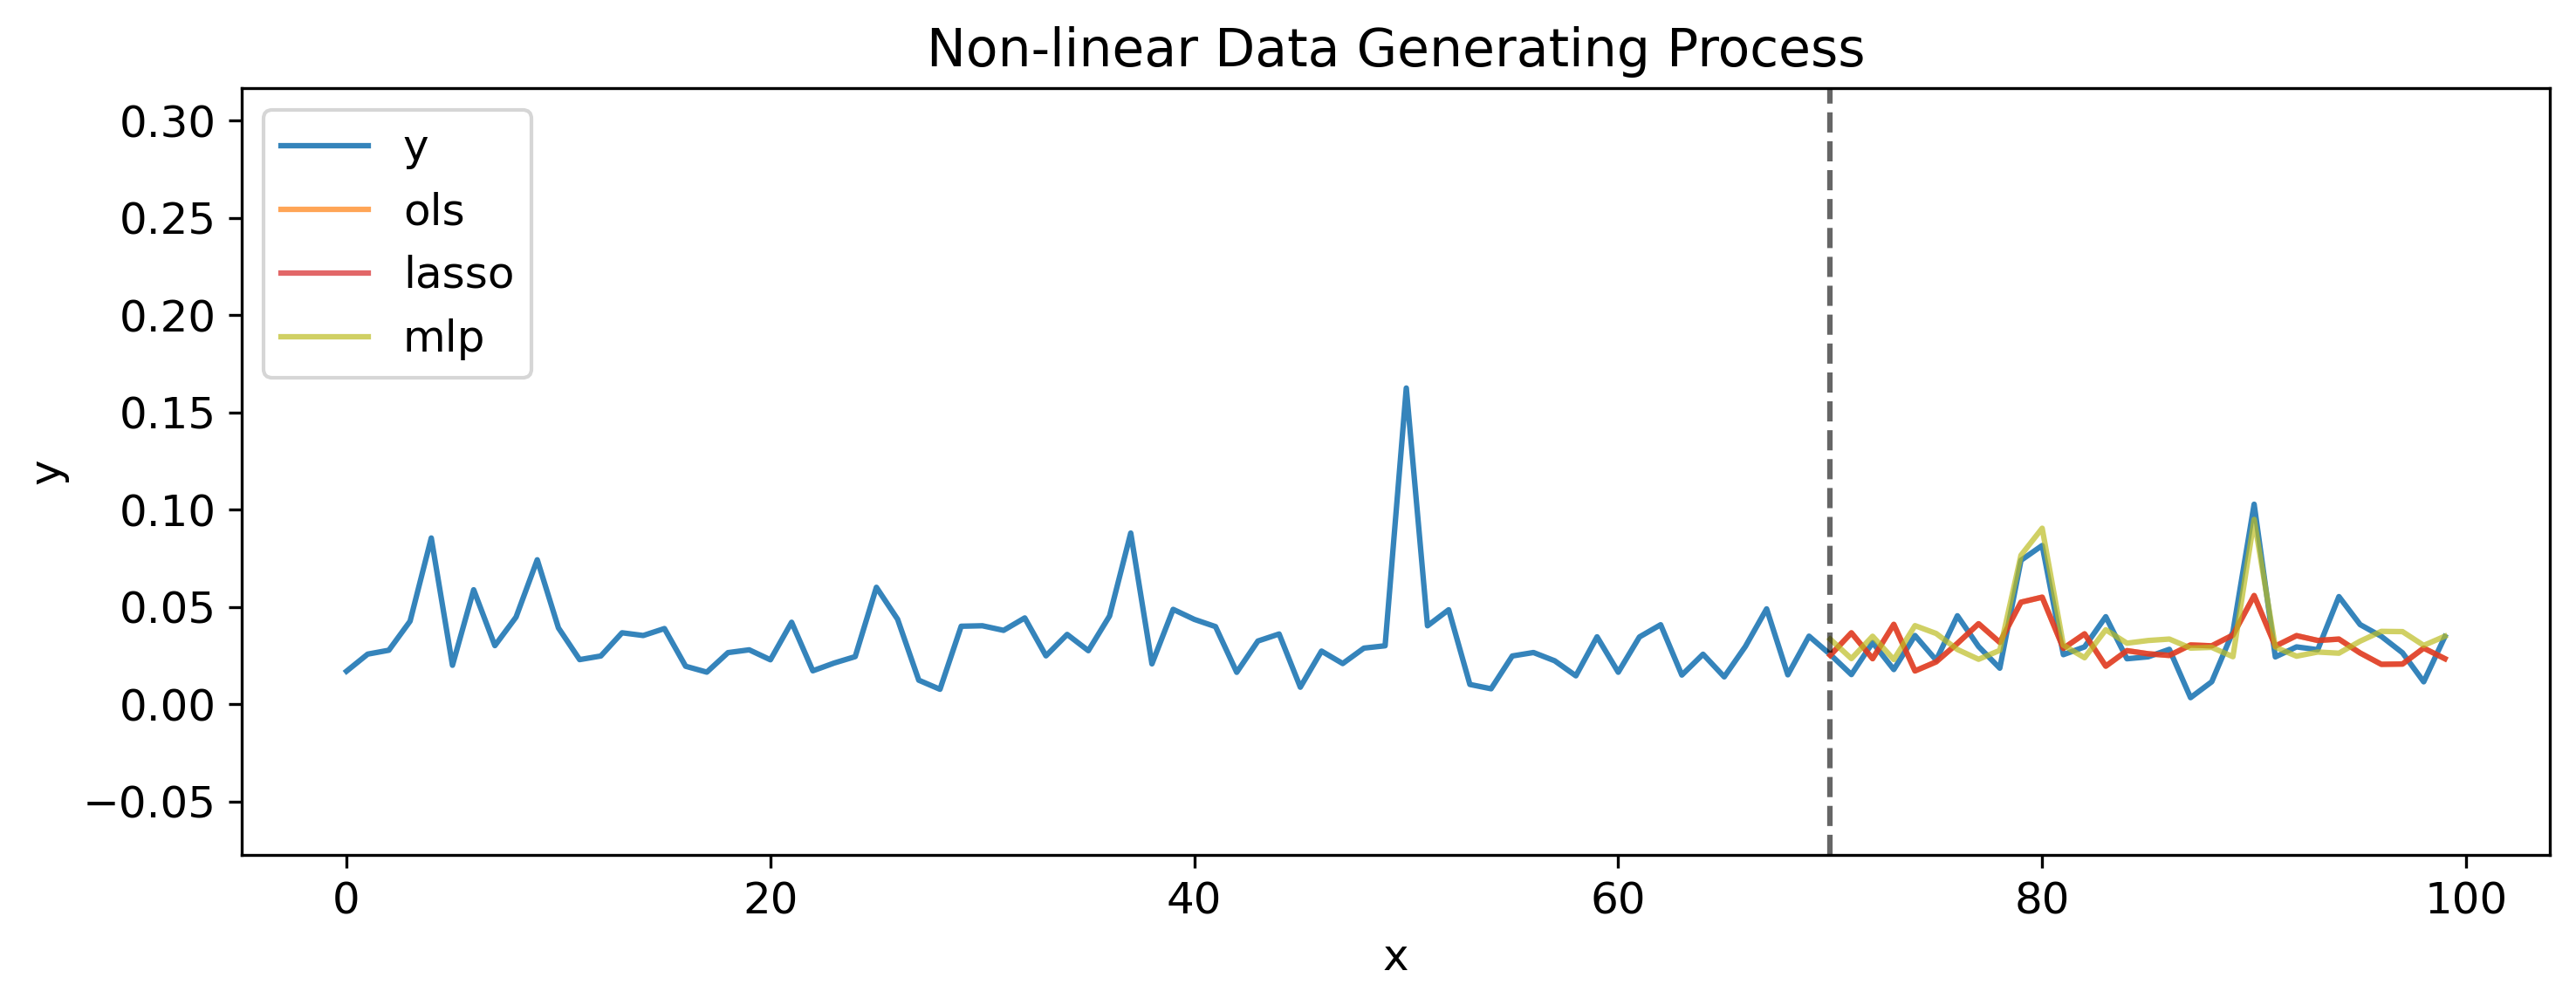

In [25]:
plt.plot(n_full, y3, label='y', color='C0', alpha=0.9)
# plt.plot(n_full, x[:,1], label='x', color='C6', alpha=0.7)

plt.plot(n_test, ols_pred3, label='ols', color='C1', alpha=0.7)
plt.plot(n_test, lasso_pred3, label='lasso', color='C3',  alpha=0.7)
plt.plot(n_test, mlp_pred3, label='mlp', color='C8', alpha=0.7)

plt.axvline(len(x_train), color='k', linestyle='--', alpha=0.6)

plt.legend(loc='upper left')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Non-linear Data Generating Process")
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.savefig('output/non-linear-simul.png', dpi=300)


plt.show()
plt.close()

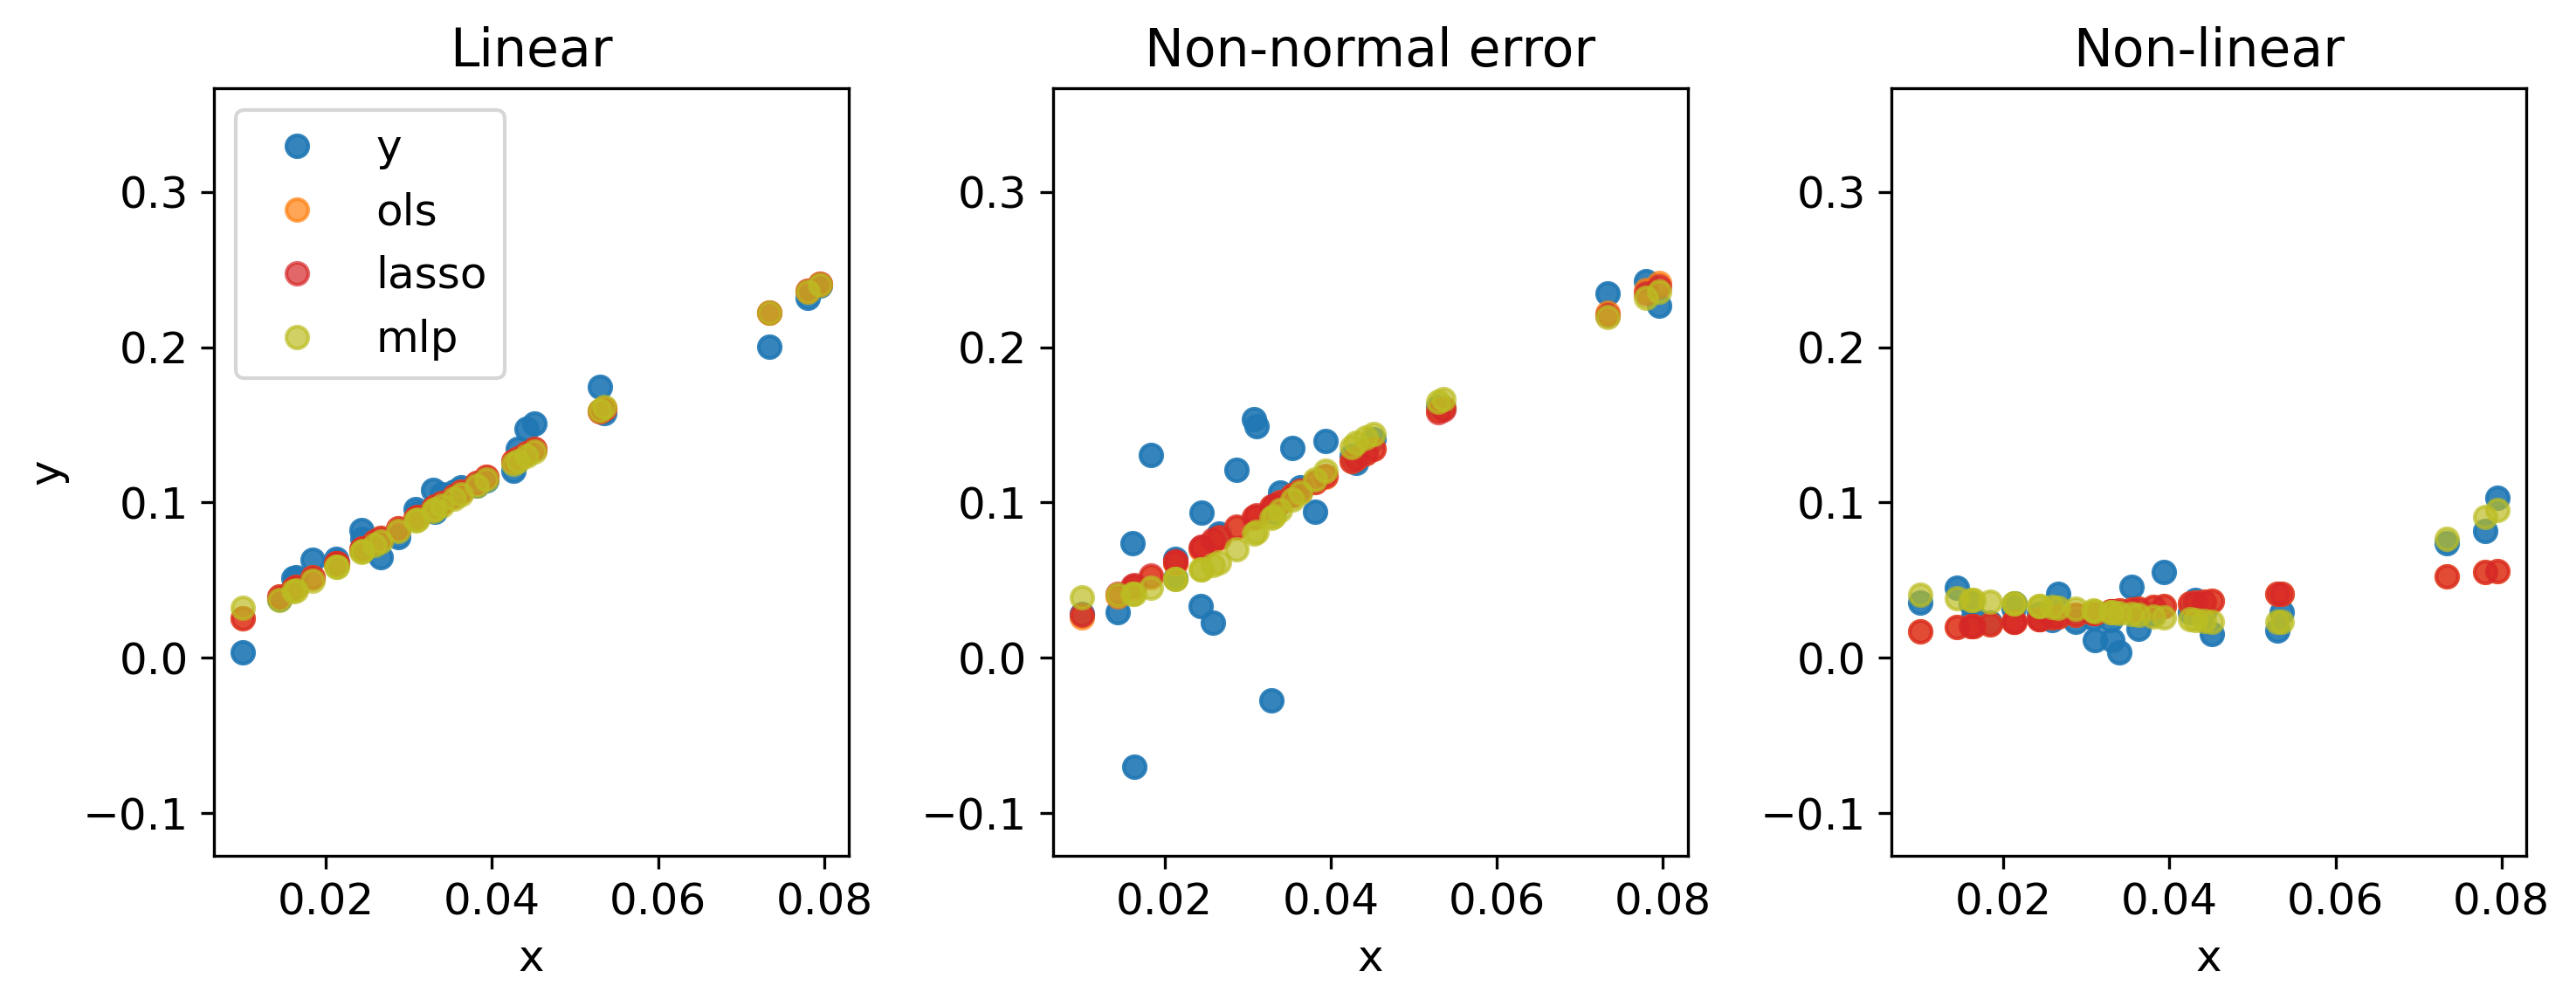

In [41]:
# plot the simulations
plt.subplot(1, 3, 1)
plt.plot(x_test[:,1], y1_test, 'o', label='y', color='C0', alpha=0.9)
plt.plot(x_test[:,1], ols_pred1, 'o', label='ols', color='C1', alpha=0.7)
plt.plot(x_test[:,1], lasso_pred1, 'o', label='lasso', color='C3',  alpha=0.7)
plt.plot(x_test[:,1], mlp_pred1, 'o', label='mlp', color='C8', alpha=0.7)
plt.ylim(y_min, y_max)
plt.legend(loc='upper left')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear')

plt.subplot(1, 3, 2)
plt.plot(x_test[:,1], y2_test, 'o', label='test', color='C0', alpha=0.9)
plt.plot(x_test[:,1], ols_pred2, 'o', label='ols', color='C1', alpha=0.7)
plt.plot(x_test[:,1], lasso_pred2, 'o', label='lasso', color='C3',  alpha=0.7)
plt.plot(x_test[:,1], mlp_pred2, 'o', label='mlp', color='C8', alpha=0.7)
plt.ylim(y_min, y_max)
plt.xlabel('x')
plt.title('Non-normal error')

plt.subplot(1, 3, 3)
plt.plot(x_test[:,1], y3_test, 'o', label='test', color='C0', alpha=0.9)
plt.plot(x_test[:,1], ols_pred3, 'o', label='ols', color='C1', alpha=0.7)
plt.plot(x_test[:,1], lasso_pred3, 'o', label='lasso', color='C3',  alpha=0.7)
plt.plot(x_test[:,1], mlp_pred3, 'o', label='mlp',  color='C8', alpha=0.7)
plt.ylim(y_min, y_max)
plt.xlabel('x')
plt.title('Non-linear')

plt.tight_layout()

plt.savefig('output/simulation-scatter.png', dpi=300)

plt.show()
plt.close()

In [27]:
# calculate the root mean squared error for each
rmse_ols1 = np.sqrt(np.mean((y1_test - ols_pred1)**2))
rmse_lasso1 = np.sqrt(np.mean((y1_test - lasso_pred1)**2))
rmse_mlp1 = np.sqrt(np.mean((y1_test - mlp_pred1)**2))

rmse_ols2 = np.sqrt(np.mean((y2_test - ols_pred2)**2))
rmse_lasso2 = np.sqrt(np.mean((y2_test - lasso_pred2)**2))
rmse_mlp2 = np.sqrt(np.mean((y2_test - mlp_pred2)**2))

rmse_ols3 = np.sqrt(np.mean((y3_test - ols_pred3)**2))
rmse_lasso3 = np.sqrt(np.mean((y3_test - lasso_pred3)**2))
rmse_mlp3 = np.sqrt(np.mean((y3_test - mlp_pred3)**2))


# create table
rmse_table = pd.DataFrame({
    'OLS': [rmse_ols1, rmse_ols2, rmse_ols3],
    'Lasso': [rmse_lasso1, rmse_lasso2, rmse_lasso3],
    'MLP': [rmse_mlp1, rmse_mlp2, rmse_mlp3]
}, index=['Linear', 'Non-normal error', 'Non-linear'])
rmse_table.index.name = 'Model'
rmse_table.columns.name = 'RMSE'

display(rmse_table)

models = ['OLS', 'Lasso', 'MLP']
metrics = {'Linear':[rmse_ols1, rmse_lasso1, rmse_mlp1],
           'Non-normal error':[rmse_ols2, rmse_lasso2, rmse_mlp2],
           'Non-linear':[rmse_ols3, rmse_lasso3, rmse_mlp3]}

rmse_tab = latex_table(models,metrics)

print(rmse_tab)

with open('output/rmse_table.tex', 'w') as f:
    f.write(rmse_tab)


RMSE,OLS,Lasso,MLP
Model,,,
Linear,0.009403,0.009403,0.010554
Non-normal error,0.041524,0.041583,0.042373
Non-linear,0.016880,0.016880,0.011236


\begin{tabular}{lccc}
\hline\hline \\ [-1.8ex]
 & OLS & Lasso & MLP \\ 
 \hline 
Linear & 0.00940 & 0.00940 & 0.01055 \\ 
Non-normal error & 0.04152 & 0.04158 & 0.04237 \\ 
Non-linear & 0.01688 & 0.01688 & 0.01124 \\ 
\hline\hline
\end{tabular}
